In [2]:
!pip install torch
!pip install pypianoroll

     |████████████████████████████████| 5.6MB 5.5MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
  Created wheel for pypianoroll: filename=pypianoroll-0.5.3-cp36-none-any.whl size=23827 sha256=8fd895abe19b39d0ee2100230ccbec421063f89e8dace36d3d0790c57983541e
  Stored in directory: /root/.cache/pip/wheels/29/c8/c0/7b240ab723c2f96b03391796bdf278de513eabf1dfb989c07f
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp36-none-any.whl size=5591953 sha256=c9bd14118b4511e7d59fd39dcd2bcb6a445336ade0723f13d83f2f4a50716295
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pypianoroll pretty-midi


In [3]:
import torch
import torch.nn as nn

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
!pip install pypianoroll

In [5]:
#データファイルのパス
!cd drive/My\ Drive

/bin/bash: line 0: cd: drive/My Drive: No such file or directory


In [6]:
#Google Drive マウント
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
#以下、入力データ
filename = "drive/My Drive/music/dataset/togetsukyo.mid" # 曲：渡月橋　歌：倉木麻衣
import pypianoroll
pianoroll = pypianoroll.parse(filename, beat_resolution=24, name='unknown')
import numpy as np
a1 = pianoroll.get_merged_pianoroll()
a1 = np.array(a1)
time_length = 2832 #曲の再生時間：1分
a1 = a1[:time_length, :]
np.shape(a1)

(2832, 128)

In [11]:
filename = "drive/My Drive/music/dataset/utautai.mid"
import pypianoroll
pianoroll = pypianoroll.parse(filename, beat_resolution=24, name='unknown')
import numpy as np
a2 = pianoroll.get_merged_pianoroll()
a2 = np.array(a2)
a2 = a2[:time_length, :]
np.shape(a2)

(2832, 128)

In [12]:
#モデル受け渡しのためのデータの形式変更
a1 = np.transpose(a1)
print(np.shape(a1))

a2 = np.transpose(a2)
print(np.shape(a2))


(128, 2832)
(128, 2832)


In [13]:
dataset = [a1,a2]

In [14]:
#音の強さを正規化
max_velosity = 90
dataset2 = []
for a in dataset:
  a = a / max_velosity #音の強さを正規化
  dataset2.append(a)

In [ ]:
# 曲[0]（渡月橋）のピアノロールデータ可視化
y = dataset2[0]
print(np.shape(aa))
mat = aa

sns.heatmap(mat)

In [ ]:
# 曲[1]（歌うたいのバラッド）のピアノロールデータ可視化

y = dataset2[1]
print(np.shape(aa))
mat = y

sns.heatmap(mat)

In [15]:
d = dataset2[0]
np.shape(d)

(128, 2832)

In [16]:
#入力データをmixするモードでなければ教師データとほとんど同じものが出力される
#mixモードでは、曲[0]と[1]を任意の比率で学習したものが出力される
input_size = time_length 
hidden_size = 50
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    self.linear1 = nn.Linear(time_length, 708)
    self.linear2 = nn.Linear(708, 200)
    self.meanL = nn.Linear(200, hidden_size)
    self.varL = nn.Linear(200, hidden_size)
    self.softplus = nn.Softplus()
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.linear3 = nn.Linear(hidden_size, 200)
    self.linear4 = nn.Linear(200, 708)
    self.linear5 = nn.Linear(708, time_length)

  def forward(self, x, zzz, zz):
    xx = self.relu(self.linear1(x))
    xx = self.relu(self.linear2(xx))
    mean = self.meanL(xx)
    var = self.softplus(self.varL(xx))
    epsilon = torch.randn(mean.size())
    epsilon = epsilon.cuda()
    z = mean + torch.sqrt(var) * epsilon

    if zz == 1: #音源をmixする
      z = zzz
      print("mix")
    y = self.relu(self.linear3(z))
    y = self.relu(self.linear4(y))
    y = self.sigmoid(self.linear5(y))
    mean = mean.view(1, hidden_size)
    var = var.view(1, hidden_size)
    x = x.view(1, time_length)
    y = y.view(1, time_length)

    return mean, var, x, y
vae = []
for i in range(128):
  vAE = VAE()
  vAE = vAE.cuda()
  vae.append(vAE)

In [17]:
class VAELoss(nn.Module):
  def __init__(self):
    super(VAELoss, self).__init__()
  
  def forward(self, mean, var, x, y):
    delta = 1e-8
    
    KL = - 0.5 * torch.mean(torch.sum(1 + torch.log(var + delta) - mean**2 - var))
    epsilon = torch.randn(mean.size())
    epsilon = epsilon.cuda()
    z = mean + torch.sqrt(var) * epsilon
    reconstruction = torch.mean(torch.sum(x * torch.log(y + delta) + (1 - x) * torch.log(1 - y + delta)))
    lower_bound = [-KL, reconstruction]                                      
    return -sum(lower_bound)

vaeloss = VAELoss()
vaeloss = vaeloss.cuda()

In [18]:
criterion = VAELoss()
import torch.optim as optim
lr = 0.001

In [19]:
import torch.optim as optim
lr = 0.0001
optimizers = []
for i in range(128):
  VAE = vae[i]
  optimizer = optim.Adam(VAE.parameters(), lr=lr)
  optimizers.append(optimizer)

In [20]:
def vaeTrain(xx, i):
  x = xx.view(1, time_length)
  VAE = vae[i]
  VAE.train()
  zzz = torch.rand(1, 50)
  zzz = zzz.cuda()
  zz = 0
  mean, var, x, y = VAE(x, zzz, zz)
  loss = criterion(mean[0], var[0], x[0], y[0])
  optimizer = optimizers[i]
  loss.backward()
  optimizer.step()
  return loss.item(), y, mean, var

In [23]:
device = torch.device('cpu')
tanh = nn.Tanh()

def train():

  a = 0 #曲[0]を入力
  print(a)
  
  train_data = torch.tensor(dataset2[a])
  train_data = train_data.cuda()
  train_data = train_data.float()

  loss = 0
  for i in range(128):
    xx = train_data[i]
    if i == 0:
      loss_i, y, mean, var = vaeTrain(xx, i)
    else:
      loss_ii, y1, mean1, var1 = vaeTrain(xx, i)
      y = torch.cat((y, y1), 0)
      mean = torch.cat((mean, mean1), 0)
      var = torch.cat((var, var1), 0)
    loss += loss_i
  
  loss = loss / 128
  
  y = y.to(device)
  y = y.detach().clone().numpy()

  return loss, y, mean, var

In [ ]:
# train 呼び出しパート
epochs = 700
train_history = []

for epoch in range(epochs):
  
  train_loss,  y, mean, var = train()
  train_history.append(train_loss)

  print(f'[Epoch {epoch+1:3d}/{epochs:3d}]' \
          f' train_loss: {train_loss:.5f}')
  print(np.shape(y))
  print(mean.size(), var.size())

Tue Jul 28 09:47:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    33W / 250W |  11687MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

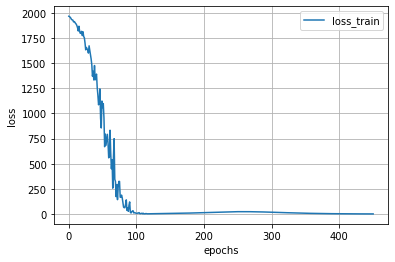

In [ ]:
!nvidia-smi

plt.plot(train_history, label='loss_train', marker='None')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
#以下、mixモードについて
def vae_mixtune(xx, i, zzz, zz):
  x = xx.view(1, time_length)
  VAE = vae[i]
  VAE.eval()
  #print(x.size())
  mean, var, x, y = VAE(x, zzz, zz)
  loss = criterion(mean[0], var[0], x[0], y[0])
  
  return loss.item(), y, mean, var

In [ ]:
def mixtune(alpha):
  zz = 1
  zzz = torch.rand(1, 50)
  zzz = zzz.cuda()
  a = 0
  print(a)
  train_data = torch.tensor(dataset2[a])
  train_data = train_data.cuda()
  train_data = train_data.float()

  loss = 0
  for i in range(128):
    xx = train_data[i]
    if i == 0:
      loss_i, y6, mean6, var6 = vae_mixtune(xx, i, zzz, zz)
    else:
      loss_ii, y1, mean1, var1 = vae_mixtune(xx, i, zzz, zz)
      y6 = torch.cat((y6, y1), 0)
      mean6 = torch.cat((mean6, mean1), 0)
      var6 = torch.cat((var6, var1), 0)
    loss += loss_i
    

    a = 1
  print(a)
  train_data = torch.tensor(dataset2[a])
  train_data = train_data.cuda()
  train_data = train_data.float()

  loss = 0
  for i in range(128):
    xx = train_data[i]
    if i == 0:
      loss_i, y7, mean7, var7 = vae_mixtune(xx, i, zzz, zz)
    else:
      loss_ii, y1, mean1, var1 = vae_mixtune(xx, i, zzz, zz)
      y7 = torch.cat((y7, y1), 0)
      mean7 = torch.cat((mean7, mean1), 0)
      var7 = torch.cat((var7, var1), 0)
    loss += loss_i
  
  y6 = y6.to(device)
  y6 = y6.detach().clone().numpy()
  y7 = y7.to(device)
  y7 = y7.detach().clone().numpy()

  #mixモードのフラグを立てている
  zz = 1
  epsilon = torch.randn(mean7.size())
  epsilon = epsilon.cuda()

  z6 = mean6 + torch.sqrt(var6) * epsilon
  z7 = mean7 + torch.sqrt(var7) * epsilon

  zzz = alpha * z6 + (1 - alpha) * z7
  zzz = zzz.cuda()


  for i in range(128):
    xx = train_data[i]
    
    if i == 0:
      loss_i, y8, mean8, var8 = vae_mixtune(xx, i, zzz[i], zz)
    else:
      loss_ii, y1, mean1, var1 = vae_mixtune(xx, i, zzz[i], zz)
      y8 = torch.cat((y8, y1), 0)
      mean8 = torch.cat((mean8, mean1), 0)
      var8 = torch.cat((var8, var1), 0)


  return y8

In [ ]:
# αを設定した後でトレーニング呼び出し部を実行する必要がある

In [ ]:
y = mixtune(0.0) #α = 0.0:曲[0]が100%になる。
y = y.to(device)
y = y.detach().clone().numpy()
mat = y

sns.heatmap(mat)

In [ ]:
y = mixtune(1.0) #α=1.0:曲[1]が100%になる。
y = y.to(device)
y = y.detach().clone().numpy()
mat = y

sns.heatmap(mat)

In [ ]:
y = mixtune(0.5)　#α = 0.5 :曲[0],曲[1]が5:5で混ざり合う
y = y.to(device)
y = y.detach().clone().numpy()
mat = y

sns.heatmap(mat)

In [ ]:
y = mixtune(0.1)　#α = 0.1:曲[0],曲[1]が9:1で混ざり合う
y = y.to(device)
y = y.detach().clone().numpy()
mat = y

sns.heatmap(mat)

In [ ]:
# train 呼び出しパート
epochs = 700
train_history = []

for epoch in range(epochs):
  
  train_loss,  y, mean, var = train()
  train_history.append(train_loss)

  print(f'[Epoch {epoch+1:3d}/{epochs:3d}]' \
          f' train_loss: {train_loss:.5f}')
  print(np.shape(y))
  print(mean.size(), var.size())

In [ ]:
# 以下、出力をmidi形式で作成
y = y * max_velosity
outputdata = np.transpose(y)
multi = pypianoroll.Multitrack()
track = Track(pianoroll=outputdata, program=0, is_drum=False,name='my awesome piano')
print(track.pianoroll.ndim)

another_track = track.copy()
multitrack = Multitrack(tracks=[track, another_track], tempo=120.0)
multitrack.write("create.mid")

2
